# SAR画像の基礎分析（雪判定）
このnotebookでは、合成開口レーダー（SAR）から得られたデータの基礎的な分析として、雪のセグメンテーションを扱います。

SARのより詳しい紹介は [こちら（外部サイト）](https://sorabatake.jp/3364/) をご覧ください。

***注意:***
* **このnotebookで取得する全てのデータはTellus上での利用に限定されます**
* **このnotebookで利用するTellus APIには一部サンプル目的のものが含まれます。これは予告なく変更される場合がございます。**
* **このnotebookでの分析の正確性については一切保証いたしません**

In [1]:
import os
import requests
import numpy as np
from skimage import io
from skimage import color
from skimage import filters
import matplotlib.pyplot as plt
%matplotlib inline

## TellusからSAR画像の取得と前処理
SARサンプルデータをTellusから取得します。SARデータにはいくつかのファイル形式が存在しますが、今回はGeoTIFF（`.tif`）形式のデータを扱います。

詳細補足: ALOS-2という衛星のPALSAR-2と呼ばれるセンサから取得され、高分解能3mモードで水平送信水平受信したL2.1のデータを扱います。PALSAR-2については [こちら（外部サイト）](https://www.eorc.jaxa.jp/ALOS-2/about/jpalsar2.htm) をご覧ください。

***注意:***
* **データサイズが非常に大きいため、完了に数分〜数十分かかる場合があります**
* **ここで利用しているAPIはサンプル目的のものです。Tellus Jupyter環境のみから利用できます。正式なAPIは今後追加される予定です。**

In [2]:
DIR_PATH = os.path.expanduser("~/work/data/")
if not os.path.exists(DIR_PATH):
    os.mkdirs(DIR_PATH, exist_ok=True)

SAR_SEP_FILE = "IMG-HH-ALOS2233612910-180920-UBSR2.1GUD.tif"
SAR_DEC_FILE = "IMG-HH-ALOS2246032910-181213-UBSR2.1GUD.tif"
SAR_SEP_PATH = os.path.join(DIR_PATH, SAR_SEP_FILE)
SAR_DEC_PATH = os.path.join(DIR_PATH, SAR_DEC_FILE)

def get_sample_data(file_id, file_path):
    if not os.path.exists(file_path):
        res = requests.get(
            "https://sample-data.app.tellusxdp.com/1/" + file_id +"/data")
        with open(file_path, 'wb') as f:
            f.write(res.content)

get_sample_data("11", SAR_SEP_PATH)
get_sample_data("14", SAR_DEC_PATH)

前処理として、クロップとクリッピングを行います。

In [3]:
path_to_fuji_trim_sep = os.path.join(DIR_PATH, "mtfuji_sep.png") # 9月のデータ
path_to_fuji_trim_dec = os.path.join(DIR_PATH, "mtfuji_dec.png") # 12月のデータ

if os.path.exists(path_to_fuji_trim_sep) and os.path.exists(path_to_fuji_trim_dec):
    # 前処理済みデータがある場合はそれを読み込んで利用
    img_fuji_sep = io.imread(path_to_fuji_trim_sep).astype(int)
    img_fuji_dec = io.imread(path_to_fuji_trim_dec).astype(int)
else:
    # SAR画像（tif形式）の読み込み
    img_fuji_sep_org = io.imread(SAR_SEP_PATH)
    img_fuji_dec_org = io.imread(SAR_DEC_PATH)

    # 前処理
    ## データが広範囲に渡るため、富士山周辺のみで切り取る
    img_fuji_sep = img_fuji_sep_org[5500:8500,4500:7500,] 
    img_fuji_dec = img_fuji_dec_org[5500:8500,4500:7500,]

    ## 外れ値を含むため、[0, 255]にクリッピング
    img_fuji_sep = np.clip(img_fuji_sep / 80 , 0, 255).astype(int)
    img_fuji_dec = np.clip(img_fuji_dec / 80 , 0, 255).astype(int)
    
    ## 前処理済みのデータを保存
    io.imsave(path_to_fuji_trim_sep, img_fuji_sep, check_contrast=False)
    io.imsave(path_to_fuji_trim_dec, img_fuji_dec, check_contrast=False)

## 基礎情報の確認
### 画像の確認
左が9月のデータ、12月データ、画像左下が山頂です。12月の方が雪の影響なのか若干全体的に暗い印象。

/opt/conda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


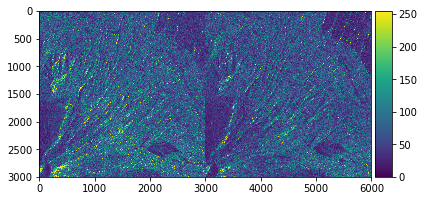

In [4]:
io.imshow(np.hstack((img_fuji_sep, img_fuji_dec)))

### 統計情報の確認

In [5]:
# 9月のデータ
print('pixel sum', np.sum(img_fuji_sep))
print('pixel mean', np.mean(img_fuji_sep))
print('pixel variance', np.var(img_fuji_sep))
print('pixel stddev', np.std(img_fuji_sep))

pixel sum 676488563
pixel mean 75.1653958889
pixel variance 1620.63042676
pixel stddev 40.2570543726


In [6]:
# 12月データ
print('pixel sum', np.sum(img_fuji_dec))
print('pixel mean', np.mean(img_fuji_dec))
print('pixel variance', np.var(img_fuji_dec))
print('pixel stddev', np.std(img_fuji_dec))

pixel sum 583237606
pixel mean 64.8041784444
pixel variance 1200.83585081
pixel stddev 34.6530785185


### ヒストグラムの確認

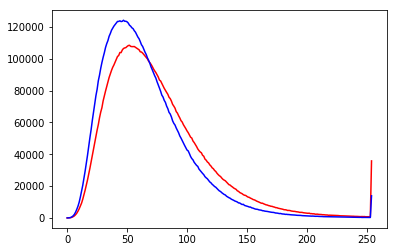

In [7]:
hists_sep, bins=np.histogram(img_fuji_sep, 255, [0, 255])
hists_dec, bins=np.histogram(img_fuji_dec, 255, [0, 255])

plt.plot(hists_sep, color='r')
plt.plot(hists_dec, color='b')

赤が9月で青が12月です。傾向が異なることが分かります。これが雪によるものなのか、その日の天候によるものなのかは定かでないため、以下で検証していきます。

## 2画像差分の確認
9月と12月のデータを比較することで、雪と思われる部分を判定してみます。

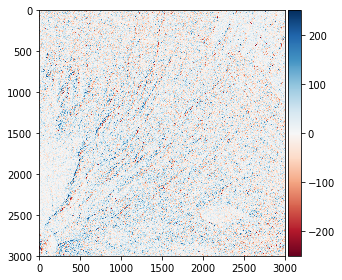

In [8]:
#差分を抽出
img_fuji_diff =  img_fuji_sep - img_fuji_dec
io.imshow(img_fuji_diff)

このままではノイズが多すぎて分からないため、ぼかしを追加します。

/opt/conda/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


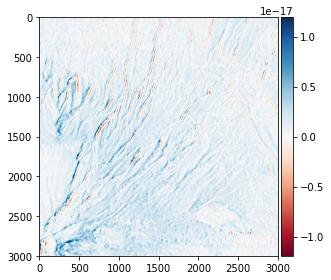

In [9]:
img_fuji_diff_gaus = filters.gaussian(img_fuji_diff, sigma=8)
io.imshow(img_fuji_diff_gaus)

見やすいように `[0, 255]` にスケールさせます。

/opt/conda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


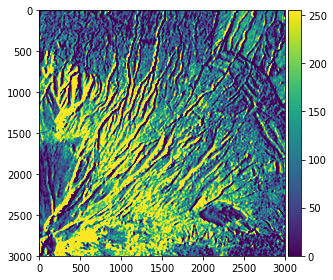

In [10]:
img_fuji_diff_gaus_norm = np.clip(img_fuji_diff_gaus * 10 ** 20 , 0, 255).astype(int)
io.imshow(img_fuji_diff_gaus_norm)

3〜5合目辺り（画像中央あたり）は変化が大きく、雪の可能性があると言えます。このnotebookでの分析はここまでですが、植生の変化など別の原因も考えられるので、より詳しい分析が必要となります。